In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
train_df = pd.read_csv("/kaggle/input/landmarkengagement-v3b/TrainEngagement_v3b.csv")
val_df = pd.read_csv("/kaggle/input/landmarkengagement-v3b/ValEngagement_v3b.csv")
test_df = pd.read_csv("/kaggle/input/landmarkengagement-v3b/TestEngagement_v3b.csv")

In [3]:
#GCN data
train_filenames = train_df['file_name'].str.split('_').str[0].values
train_labels = train_df['labels'].values
train_df = train_df.drop(columns=['file_name', 'labels']).values

val_filenames = val_df['file_name'].str.split('_').str[0].values
val_labels = val_df['labels'].values
val_df = val_df.drop(columns=['file_name', 'labels']).values

test_filenames = test_df['file_name'].str.split('_').str[0].values
test_labels = test_df['labels'].values
test_df = test_df.drop(columns=['file_name', 'labels']).values

In [4]:
minmax_scaler = MinMaxScaler()
train_df = minmax_scaler.fit_transform(train_df)
val_df = minmax_scaler.transform(val_df)
test_df = minmax_scaler.transform(test_df)

In [5]:
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [6]:
train_df = torch.tensor(train_df, dtype=torch.float32).unsqueeze(1)
val_df = torch.tensor(val_df, dtype=torch.float32).unsqueeze(1)
test_df = torch.tensor(test_df, dtype=torch.float32).unsqueeze(1)

In [7]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, features, labels, filenames):
        self.features = features
        self.labels = labels
        self.filenames = filenames

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        filename = self.filenames[idx]
        return feature, label, filename

In [8]:
train_dataset = CustomDataset(train_df, train_labels, train_filenames)
val_dataset = CustomDataset(val_df, val_labels, val_filenames)
test_dataset = CustomDataset(test_df, test_labels, test_filenames)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
class Simple1DCNN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(hidden_dim * 2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(4352, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
model = Simple1DCNN(num_features=136, hidden_dim=32, num_classes=4).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

Simple1DCNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4352, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=4, bias=True)
)


In [12]:
def train(train_loader):
    model.train()
    video_outputs = {}
    video_labels = {}
    total_loss = 0
    correct = 0

    for data in train_loader:
        cnn_features, cnn_labels, cnn_filenames = data
        cnn_features = cnn_features.to(device)
        cnn_labels = cnn_labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(cnn_features)
        loss = loss_fn(outputs, cnn_labels)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        softmax_out = outputs.softmax(dim=1).detach().cpu().numpy()
        labels = cnn_labels.cpu().numpy()

        # Aggregate predictions by video filename
        for filename, pred, label in zip(cnn_filenames, softmax_out, labels):
            if filename not in video_outputs:
                video_outputs[filename] = np.zeros(pred.shape)
                video_labels[filename] = label
            video_outputs[filename] += pred

    # Calculate video-level predictions
    final_preds = []
    final_labels = []

    for filename in video_outputs:
        video_prediction = np.argmax(video_outputs[filename])
        final_preds.append(video_prediction)
        final_labels.append(video_labels[filename])

    train_accuracy = np.sum(np.array(final_preds) == np.array(final_labels)) / len(final_labels)
    train_loss = total_loss / len(train_loader.dataset)
    return train_loss, train_accuracy


In [13]:
def evaluate(val_loader):
    model.eval()
    video_outputs = {}
    video_labels = {}

    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            cnn_features, cnn_labels, cnn_filenames = data
            cnn_features = cnn_features.to(device)
            cnn_labels = cnn_labels.to(device)

            outputs = model(cnn_features)
            val_loss += loss_fn(outputs, cnn_labels).item()

            softmax_out = outputs.softmax(dim=1).detach().cpu().numpy()
            labels = cnn_labels.cpu().numpy()

            # Aggregate predictions by video filename
            for filename, pred, label in zip(cnn_filenames, softmax_out, labels):
                if filename not in video_outputs:
                    video_outputs[filename] = np.zeros(pred.shape)
                    video_labels[filename] = label
                video_outputs[filename] += pred

    # Calculate video-level predictions
    final_preds = []
    final_labels = []

    for filename in video_outputs:
        video_prediction = np.argmax(video_outputs[filename])
        final_preds.append(video_prediction)
        final_labels.append(video_labels[filename])

    val_accuracy = np.sum(np.array(final_preds) == np.array(final_labels)) / len(final_labels)
    val_loss /= len(val_loader.dataset)
    return val_loss, val_accuracy


In [14]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0
best_model_weights = None


for epoch in range(num_epochs):
    train_loss, train_accuracy = train(train_loader)
    val_loss, val_accuracy = evaluate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
print(f"best val acc: {best_val_accuracy}")
torch.save(best_model_weights, 'model_cnn_landmark.pth')


Epoch 1, Train Loss: 0.0229, Train Accuracy: 0.6659, Val Loss: 0.0398, Val Accuracy: 0.5036
Epoch 2, Train Loss: 0.0210, Train Accuracy: 0.7027, Val Loss: 0.0458, Val Accuracy: 0.5042
Epoch 3, Train Loss: 0.0200, Train Accuracy: 0.7230, Val Loss: 0.0512, Val Accuracy: 0.4851
Epoch 4, Train Loss: 0.0194, Train Accuracy: 0.7373, Val Loss: 0.0553, Val Accuracy: 0.4982
Epoch 5, Train Loss: 0.0188, Train Accuracy: 0.7501, Val Loss: 0.0601, Val Accuracy: 0.5089
Epoch 6, Train Loss: 0.0184, Train Accuracy: 0.7609, Val Loss: 0.0609, Val Accuracy: 0.4661
Epoch 7, Train Loss: 0.0181, Train Accuracy: 0.7694, Val Loss: 0.0612, Val Accuracy: 0.5018
Epoch 8, Train Loss: 0.0178, Train Accuracy: 0.7814, Val Loss: 0.0676, Val Accuracy: 0.4756
Epoch 9, Train Loss: 0.0175, Train Accuracy: 0.7878, Val Loss: 0.0654, Val Accuracy: 0.5060
Epoch 10, Train Loss: 0.0173, Train Accuracy: 0.7918, Val Loss: 0.0711, Val Accuracy: 0.5024
best val acc: 0.5089285714285714


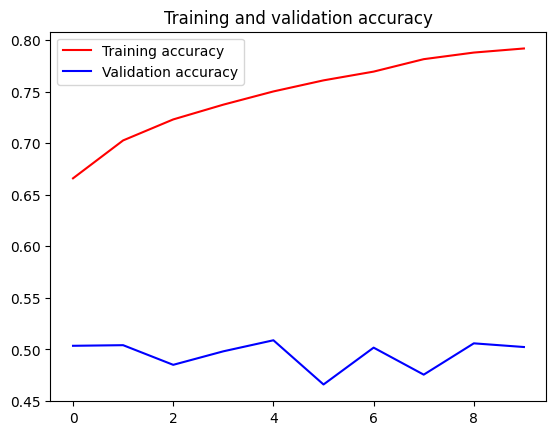

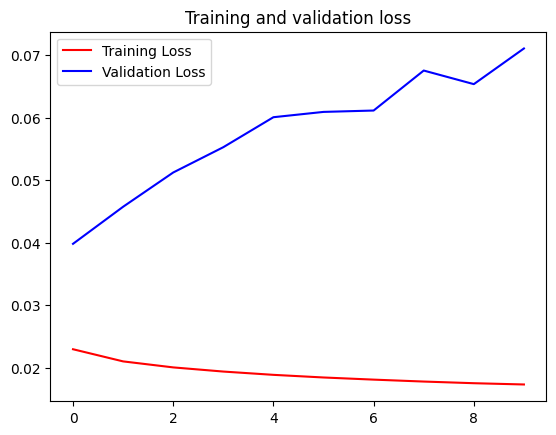

In [15]:
acc = train_accuracies
val_acc = val_accuracies
loss = train_losses
val_loss = val_losses

epochs = range(len(acc))                                                                                                                                                                                                                                                                                                                    

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
model.load_state_dict(torch.load('model_cnn_landmark.pth'))

<All keys matched successfully>

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
def test_model_cnn(test_loader):
    model.eval()
    video_outputs = {}
    video_labels = {}

    with torch.no_grad():
        for data in test_loader:
            cnn_features, cnn_labels, cnn_filenames = data
            cnn_features = cnn_features.to(device)

            out = model(cnn_features)
            softmax_out = out.softmax(dim=1).detach().cpu().numpy()
            labels = cnn_labels.cpu().numpy()

            # Aggregate predictions by video filename
            for filename, pred, label in zip(cnn_filenames, softmax_out, labels):
                if filename not in video_outputs:
                    video_outputs[filename] = np.zeros(pred.shape)
                    video_labels[filename] = label
                video_outputs[filename] += pred

    # Calculate video-level predictions
    final_preds = []
    final_labels = []

    for filename in video_outputs:
        video_prediction = np.argmax(video_outputs[filename])
        final_preds.append(video_prediction)
        final_labels.append(video_labels[filename])

    return np.array(final_preds), np.array(final_labels)

# Example usage
test_preds, test_true = test_model_cnn(test_loader)
test_accuracy = np.sum(test_preds == test_true) / len(test_true)
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.4961


In [18]:
print("Frame-Level Classification Report (Test):")
print(classification_report(test_true, test_preds, zero_division=0))

Frame-Level Classification Report (Test):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.24      0.06      0.10        84
           2       0.51      0.74      0.60       900
           3       0.47      0.27      0.34       796

    accuracy                           0.50      1784
   macro avg       0.30      0.27      0.26      1784
weighted avg       0.48      0.50      0.46      1784



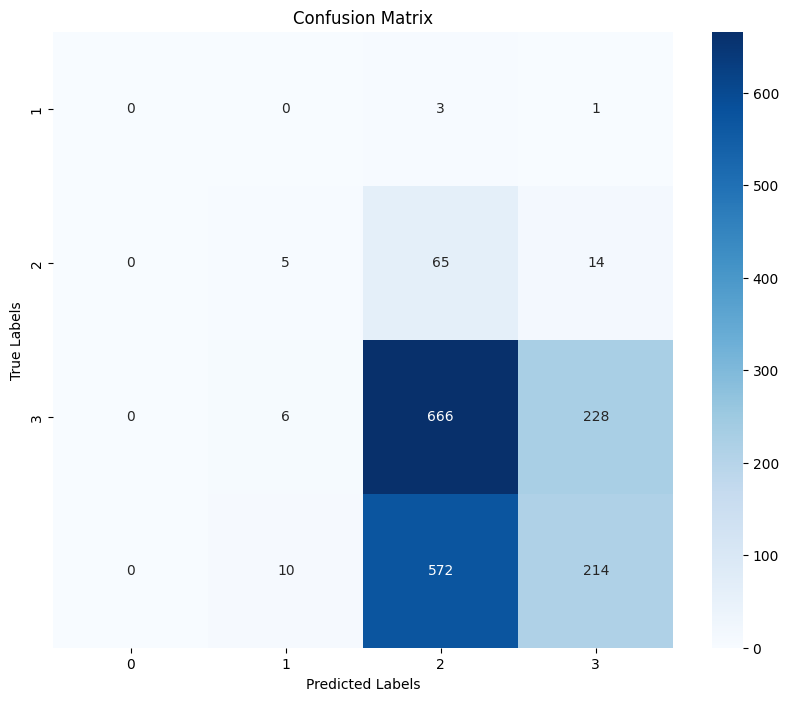

In [19]:
conf_matrix = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_true), yticklabels=np.unique(test_preds))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()